# Paper Figures: Figure 4B - Dopamine AUC Aligned to Sigmoidal Transitions

This notebook generates extended Figure 4 showing dopamine (photometry) response aligned to the transition point where animals shift cluster membership. Uses sigmoidal transition points calculated in `src/assemble_all_data.py`.

**Figure 4B: Transition-Aligned Dopamine Response** — Photometry AUC heatmaps and time series for each rat, centered at their individual transition points.

In [66]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from scipy.optimize import curve_fit

# Add src to path for importing local modules
sys.path.insert(0, str(Path("../src").resolve()))
from pickle_compat import enable_dill_pathlib_compat
enable_dill_pathlib_compat()

from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP_DIV,
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    SAVE_FIGS
)
from figure_plotting import (
    save_figure, scale_vlim_to_data, make_heatmap
)

from utils import (
    make_realigned_trials
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP_DIV  # Use shared colormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Assembled Data
Load the complete dataset with transition points and trial-aligned indices.

In [7]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - x_array has trial_aligned column: {'trial_aligned' in x_array.columns}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"\nDeplete + 45NaCl subset:")
d45_subset = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'")
d45_aligned = d45_subset.dropna(subset=['trial_aligned'])
print(f"  - Total trials: {len(d45_subset)}")
print(f"  - Trials with valid alignment: {len(d45_aligned)}")
print(f"  - Number of unique animals: {d45_aligned['id'].nunique()}")

Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 19)
  - x_array has trial_aligned column: True
  - snips_photo shape: (1960, 200)

Deplete + 45NaCl subset:
  - Total trials: 490
  - Trials with valid alignment: 392
  - Number of unique animals: 8


## Prepare Realigned Data

In [8]:
# Get the deplete + 45NaCl animals with valid transition fits
subset_aligned = (
    x_array
    .query("condition == 'deplete' & infusiontype == '45NaCl'")
    .dropna(subset=['trial_aligned'])
    .reset_index(drop=True)
    .sort_values(['id', 'trial'])
)

# Get animal info
animals = sorted(subset_aligned['id'].unique())
print(f"Animals with both transitions and deplete+45NaCl trials: {animals}")
print(f"Number of animals: {len(animals)}")

# Show summary statistics
print(f"\nTrial counts per animal:")
for animal in animals:
    n_trials = len(subset_aligned.query("id == @animal"))
    print(f"  {animal}: {n_trials} trials")

Animals with both transitions and deplete+45NaCl trials: ['PB26', 'PB30', 'PB31', 'PB46', 'PB71', 'PB72', 'PB73', 'PB75']
Number of animals: 8

Trial counts per animal:
  PB26: 49 trials
  PB30: 49 trials
  PB31: 49 trials
  PB46: 49 trials
  PB71: 49 trials
  PB72: 49 trials
  PB73: 49 trials
  PB75: 49 trials


## Figure 4B: Transition-Aligned Heatmaps

## Helper Functions for Plotting

In [9]:
# Define sigmoid function for fitting
def sigmoid(x, L, x0, k, b):
    """4-parameter sigmoid function."""
    return L / (1 + np.exp(-k * (x - x0))) + b


def plot_auc_and_sigmoid(df, column, ax=None, first_trial=0, include_steepness=True):
    """Plot AUC data grouped by column with sigmoid fit."""
    if ax is None:
        f, ax = plt.subplots(figsize=(3, 3))

    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    sd = df.groupby(column).std(numeric_only=True).auc_snips.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[3], linestyle="", marker="o", markersize=5, 
            markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y - sem, y + sem, color=colors[3], alpha=0.1)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[3], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, np.max(y) * 0.9, f"k = {popt[2]:.2f}", 
                    color=colors[3], fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return popt
    except Exception as e:
        print(f"Failed to fit sigmoid: {e}")
        return None




def plot_realigned_behaviour(df, column, ax=None, first_trial=0, include_steepness=False):
    """Plot behavior (time_moving) grouped by column with sigmoid fit."""
    if ax is None:
        f, ax = plt.subplots(figsize=(3, 3))

    mean = df.groupby(column).mean(numeric_only=True).time_moving
    sd = df.groupby(column).std(numeric_only=True).time_moving.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[1], linestyle="", marker="o", markersize=5, 
            markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y - sem, y + sem, color=colors[1], alpha=0.1)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[1], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, np.max(y) * 0.9, f"k = {popt[2]:.2f}", 
                    color=colors[1], fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return popt
    except Exception as e:
        print(f"Failed to fit sigmoid: {e}")
        return None

    sns.despine(ax=ax, offset=5, right=True)
    ax.set_yticks([])
    ax.set_ylabel("Time Moving")

## Figure 4B-1: Original vs. Realigned AUC Comparison

Original order - transition midpoint: 16.1, steepness (k): -0.206
Realigned - transition midpoint: 1.2, steepness (k): -1.028


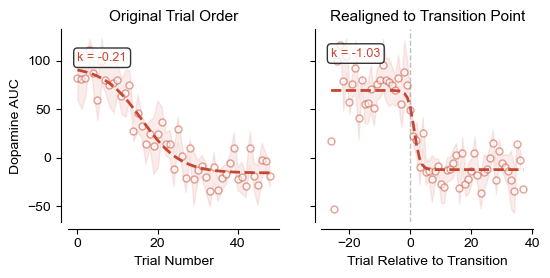

In [12]:
# Compare original vs realigned AUC
f, ax = plt.subplots(ncols=2, figsize=(6, 2.5), sharey=True)

# Left plot: Original trial order
popt_orig = plot_auc_and_sigmoid(subset_aligned, "trial", ax=ax[0], include_steepness=True)
ax[0].set_xlabel('Trial Number', fontsize=10)
ax[0].set_title('Original Trial Order', fontsize=11)
ax[0].set_ylabel('Dopamine AUC', fontsize=10)

# Right plot: Realigned to transition
popt_realigned = plot_auc_and_sigmoid(subset_aligned, "trial_aligned", ax=ax[1], 
                                      first_trial=int(subset_aligned.trial_aligned.min()),
                                      include_steepness=True)
ax[1].set_xlabel('Trial Relative to Transition', fontsize=10)
ax[1].set_title('Realigned to Transition Point', fontsize=11)


# Mark transition point
ax[1].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

sns.despine(ax=ax[0], offset=5)
sns.despine(ax=ax[1], offset=5)

if SAVE_FIGS:
    save_figure(f, "fig4b_realigned_transitions", FIGSFOLDER)


print(f"Original order - transition midpoint: {popt_orig[1]:.1f}, steepness (k): {popt_orig[2]:.3f}")
print(f"Realigned - transition midpoint: {popt_realigned[1]:.1f}, steepness (k): {popt_realigned[2]:.3f}")

## Figure 4B-2: Dopamine and Behavior Co-Aligned to Transition

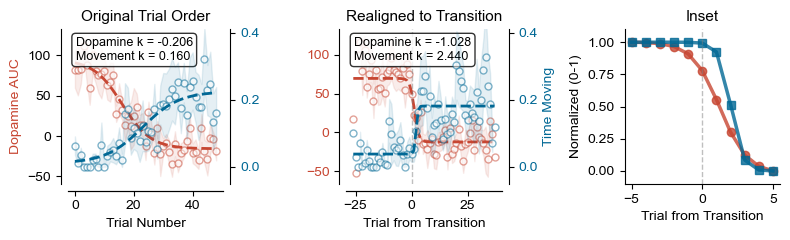


Steepness of transitions (k values):
  Original trial order:
    Dopamine:   -0.206
    Movement:    0.160
  Realigned to transition:
    Dopamine:   -1.028
    Movement:    2.440
  Right panel (-5 to +5 trials window): reuses fitted parameters from middle panel


In [45]:
# Combined figure: Original order, Realigned, and Normalized window (-5 to +5)
f, ax = plt.subplots(ncols=3, figsize=(8, 2.5))

# First, fit movement sigmoids for original and realigned
movement_by_trial_orig = subset_aligned.groupby('trial')['time_moving'].mean()
movement_by_trial_realigned = subset_aligned.groupby('trial_aligned')['time_moving'].mean()

try:
    popt_behav_orig, _ = curve_fit(sigmoid, movement_by_trial_orig.index.values, movement_by_trial_orig.values,
                                   p0=[max(movement_by_trial_orig.values), np.median(movement_by_trial_orig.index), 1, min(movement_by_trial_orig.values)],
                                   maxfev=10000)
    k_behav_orig = popt_behav_orig[2]

except Exception as e:
    k_behav_orig = np.nan
    print(f"Failed to fit movement (original): {e}")

try:
    popt_behav_realigned, _ = curve_fit(sigmoid, movement_by_trial_realigned.index.values, movement_by_trial_realigned.values,
                                        p0=[max(movement_by_trial_realigned.values), np.median(movement_by_trial_realigned.index), 1, min(movement_by_trial_realigned.values)],
                                        maxfev=10000)
    k_behav_realigned = popt_behav_realigned[2]
except Exception as e:
    k_behav_realigned = np.nan
    print(f"Failed to fit movement (realigned): {e}")

# Left plot: Original trial order with dual axes
plot_auc_and_sigmoid(subset_aligned, "trial", ax=ax[0], include_steepness=False)
ax[0].set_xlabel('Trial Number', fontsize=10)
ax[0].set_title('Original Trial Order', fontsize=11)
ax[0].set_ylabel('Dopamine AUC', fontsize=10, color=colors[3])
# Add steepness text for both curves
ax[0].text(0.05, 0.95, f"Dopamine k = {popt_orig[2]:.3f}\nMovement k = {k_behav_orig:.3f}", 
          transform=ax[0].transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2_left = ax[0].twinx()
plot_realigned_behaviour(subset_aligned, "trial", ax=ax2_left, include_steepness=False)

# Middle plot: Realigned to transition with dual axes
plot_auc_and_sigmoid(subset_aligned, "trial_aligned", ax=ax[1], 
                    first_trial=int(subset_aligned.trial_aligned.min()),
                    include_steepness=False)
ax[1].set_xlabel('Trial from Transition', fontsize=10)
ax[1].set_title('Realigned to Transition', fontsize=11)
ax[1].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

ax[1].tick_params(axis='y', labelcolor=colors[3])
# Add steepness text for both curves
ax[1].text(0.05, 0.95, f"Dopamine k = {popt_realigned[2]:.3f}\nMovement k = {k_behav_realigned:.3f}", 
          transform=ax[1].transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2_mid = ax[1].twinx()
ax2_mid.sharey(ax2_left)
plot_realigned_behaviour(subset_aligned, "trial_aligned", ax=ax2_mid,
                        first_trial=int(subset_aligned.trial_aligned.min()),
                        include_steepness=False)
ax2_mid.set_ylabel('Time Moving', fontsize=10, color=colors[1])

for axis in [ax2_left, ax2_mid]:
    sns.despine(ax=axis, offset=5, left=True, right=False)
    axis.spines['right'].set_position(('outward', 5))
    axis.tick_params(axis='y', labelcolor=colors[1])
    axis.set_ylim([-0.05, 0.41])
    axis.set_yticks([0,0.2,0.4])

# Right plot: Normalized fitted curves in -5 to +5 window
window_trials = np.arange(-5, 6)

# Use the already-fitted sigmoid parameters from the middle panel
y_dop_fit = sigmoid(window_trials, *popt_realigned)
y_behav_fit = sigmoid(window_trials, *popt_behav_realigned)

# Normalize both fitted curves to 0-1 scale independently
dop_min, dop_max = y_dop_fit.min(), y_dop_fit.max()
behav_min, behav_max = y_behav_fit.min(), y_behav_fit.max()

dopamine_norm = (y_dop_fit - dop_min) / (dop_max - dop_min) if dop_max > dop_min else np.ones_like(y_dop_fit) * 0.5
behavior_norm = (y_behav_fit - behav_min) / (behav_max - behav_min) if behav_max > behav_min else np.ones_like(y_behav_fit) * 0.5

# Invert behavior so it goes from high to low (like dopamine)
behavior_inverted = 1 - behavior_norm

# Plot on right axes
ax[2].plot(window_trials, dopamine_norm, 'o-', color=colors[3], linewidth=2.5, 
        markersize=6, label='Dopamine', alpha=0.8)
ax[2].plot(window_trials, behavior_inverted, 's-', color=colors[1], linewidth=2.5, 
        markersize=6, label='Movement (inverted)', alpha=0.8)
ax[2].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax[2].set_xlabel('Trial from Transition', fontsize=10)
ax[2].set_ylabel('Normalized (0-1)', fontsize=10)
ax[2].set_title('Inset', fontsize=11)
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_xticks([-5, 0, 5])

sns.despine(ax=ax[2])

sns.despine(ax=ax[0], offset=5)
sns.despine(ax=ax[1], offset=5)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_realigned_transitions_with_behavior", FIGSFOLDER)
plt.show()

# Print summary of steepness values
print(f"\nSteepness of transitions (k values):")
print(f"  Original trial order:")
print(f"    Dopamine:  {popt_orig[2]:7.3f}")
print(f"    Movement:  {k_behav_orig:7.3f}")
print(f"  Realigned to transition:")
print(f"    Dopamine:  {popt_realigned[2]:7.3f}")
print(f"    Movement:  {popt_behav_realigned[2]:7.3f}")
print(f"  Right panel (-5 to +5 trials window): reuses fitted parameters from middle panel")

## Figure 4C: Cross-Correlation Analysis (Dopamine vs Behavior, -5 to +5 trials)

Compute cross-correlation between normalized dopamine and behavior signals within ±5 trials of transition to determine temporal lag between signals for each animal.

In [107]:
from scipy.signal import correlate

# Compute cross-correlation for each animal using trial-by-trial values
cross_corr_results = []

for animal in animals:
    # Get this animal's data restricted to -5 to +5 trials, sorted by trial_aligned
    animal_data = subset_aligned.query("id == @animal & trial_aligned >= -15 & trial_aligned <= 15").sort_values('trial_aligned')
    
    if len(animal_data) < 5:
        print(f"Warning: {animal} has {len(animal_data)} trials in [-5, +5] window - skipping")
        continue
    
    # Extract trial-by-trial values
    dopamine_auc = animal_data['auc_snips'].values
    time_moving = animal_data['time_moving'].values
    trial_aligned = animal_data['trial_aligned'].values
    
    # Normalize each to [0, 1]
    dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
    behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)
    
    # Compute cross-correlation between trial-by-trial values
    cross_corr = correlate(dopamine_norm, behavior_norm, mode='full')
    
    # Lags range from -(n_trials-1) to +(n_trials-1)
    n_trials = len(dopamine_norm)
    lags = np.arange(-(n_trials-1), n_trials)
    
    # Restrict to valid lags within [-5, +5] window
    valid_lag_mask = (lags >= -5) & (lags <= 5)
    valid_lags = lags[valid_lag_mask]
    valid_cross_corr = cross_corr[valid_lag_mask]
    
    # Find lag at maximum correlation (within valid range)
    if len(valid_cross_corr) > 0:
        max_lag_idx = np.argmax(np.abs(valid_cross_corr))
        max_lag = valid_lags[max_lag_idx]
        max_corr = valid_cross_corr[max_lag_idx]
    else:
        max_lag = np.nan
        max_corr = np.nan
    
    # Also compute Pearson correlation coefficient
    from scipy.stats import pearsonr
    pearson_r, p_value = pearsonr(dopamine_norm, behavior_norm)
    
    cross_corr_results.append({
        'animal': animal,
        'lag_trials': max_lag,
        'max_correlation': max_corr,
        'pearson_r': pearson_r,
        'p_value': p_value,
        'n_trials': len(animal_data),
    })

cross_corr_df = pd.DataFrame(cross_corr_results)

print("\nTrial-by-Trial Cross-Correlation Analysis (Dopamine AUC vs Time Moving)")
print("Window: -5 to +5 trials from transition")
print(cross_corr_df.to_string(index=False))
print(f"\nLag Summary (in trials):")
print(f"  Mean lag: {cross_corr_df['lag_trials'].mean():.2f} trials")
print(f"  Median lag: {cross_corr_df['lag_trials'].median():.2f} trials")
print(f"  Std: {cross_corr_df['lag_trials'].std():.2f} trials")
print(f"\nMean Pearson correlation: {cross_corr_df['pearson_r'].mean():.3f}")



Trial-by-Trial Cross-Correlation Analysis (Dopamine AUC vs Time Moving)
Window: -5 to +5 trials from transition
animal  lag_trials  max_correlation  pearson_r  p_value  n_trials
  PB26          -3         1.801781  -0.393873 0.028354        31
  PB30          -2         1.081886  -0.044067 0.823801        28
  PB31          -5         3.215134  -0.464230 0.008519        31
  PB46          -3         4.722735  -0.329933 0.069887        31
  PB71           2         1.481038  -0.421146 0.022896        29
  PB72          -5         2.351627  -0.246426 0.215311        27
  PB73          -4         2.285320  -0.449707 0.011142        31
  PB75          -4         7.018754  -0.605384 0.000308        31

Lag Summary (in trials):
  Mean lag: -3.00 trials
  Median lag: -3.50 trials
  Std: 2.27 trials

Mean Pearson correlation: -0.369


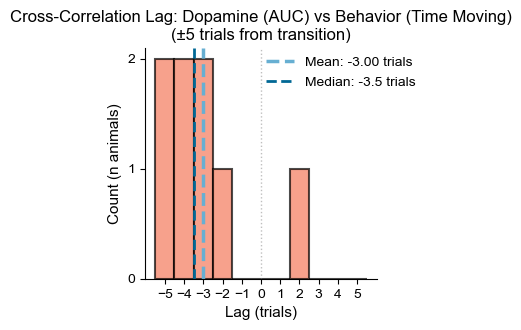

In [108]:
# Plot histogram of lags
f, ax = plt.subplots(figsize=(3, 3))

# Histogram of trial-by-trial lags
ax.hist(cross_corr_df['lag_trials'], bins=np.arange(-5.5, 6.5, 1), 
        color=colors[2], alpha=0.7, edgecolor='k', linewidth=1.5)
ax.axvline(cross_corr_df['lag_trials'].mean(), color=colors[0], linestyle='--', linewidth=2.5,
          label=f'Mean: {cross_corr_df["lag_trials"].mean():.2f} trials')
ax.axvline(cross_corr_df['lag_trials'].median(), color=colors[1], linestyle='--', linewidth=2,
          label=f'Median: {cross_corr_df["lag_trials"].median():.1f} trials')
ax.axvline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Lag (trials)', fontsize=11)
ax.set_ylabel('Count (n animals)', fontsize=11)
ax.set_title('Cross-Correlation Lag: Dopamine (AUC) vs Behavior (Time Moving)\n(±5 trials from transition)', fontsize=12)
ax.set_xticks(range(-5, 6))
ax.set_yticks([0,1,2])
ax.legend(fontsize=10, loc=[0.5, 0.8], frameon=False)
sns.despine(ax=ax)

if SAVE_FIGS:
    save_figure(f, "fig4b_cross_correlation_lag", FIGSFOLDER)



## Figure 4D: Shuffled data

In [ ]:
# shuffle rows in df_fitted
# run realignment
# fit sigmoidal and add to list
# plot hist of shuffled
# calc proportion that are greater

def fit_sigmoid(df, column, parameter):
    mean = df.groupby(column).mean(numeric_only=True)[parameter]
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return np.nan

PARAMETER = "auc_snips"

z = subset_aligned.copy()
real_k = fit_sigmoid(z, "trial_aligned", PARAMETER)[2]

num_repeats = 1000
shuffled_k = np.zeros(num_repeats)
for i in range(num_repeats):
    shuffled_x0s = fits_df.x0_orig.values
    np.random.shuffle(shuffled_x0s)
    df_fitted_params_shuffled = fits_df.assign(x0_orig=shuffled_x0s)
    z_temp = make_realigned_trials(z, df_fitted_params_shuffled, verbose=False)
    shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned", PARAMETER)[2]

print(real_k)
# print(shuffled_k)

c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


-1.0283751337151101


In [84]:
def fit_sigmoid(df, column, parameter, initial_k=1):
    mean = df.groupby(column).mean(numeric_only=True)[parameter]
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), initial_k, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return [np.nan]*4
    
def get_shuffled_k(df, parameter, num_repeats=1000, initial_k=1, verbose=False):
    z = df.copy()
    real_k = fit_sigmoid(z, "trial_aligned", parameter, initial_k=initial_k)[2]

    shuffled_k = np.zeros(num_repeats)
    for i in range(num_repeats):
        shuffled_x0s = fits_df.x0_orig.values
        np.random.shuffle(shuffled_x0s)
        df_fitted_params_shuffled = fits_df.assign(x0_orig=shuffled_x0s)
        z_temp = make_realigned_trials(z, df_fitted_params_shuffled, verbose=False)
        shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned", parameter, initial_k=initial_k)[2]
        if verbose:
            print(shuffled_k[i])

    return real_k, shuffled_k


get_shuffled_k(subset_aligned, "time_moving", num_repeats=10, initial_k=1, verbose=True)

18.849329398636193
0.20580976862367123
0.05773699651618333
0.11680978177902412
0.08681934393468596
0.179224093840317
0.04677888263292175
0.19166272580902532
0.05174458206417772
0.3365169529505846


(np.float64(2.4397416536387744),
 array([18.8493294 ,  0.20580977,  0.057737  ,  0.11680978,  0.08681934,
         0.17922409,  0.04677888,  0.19166273,  0.05174458,  0.33651695]))

In [102]:
real_k_da, shuffled_k_da = get_shuffled_k(subset_aligned, "auc_snips", num_repeats=1000, initial_k=-1)

In [ ]:
rea

Text(0.5, 0, 'Steepness of transition (k)')

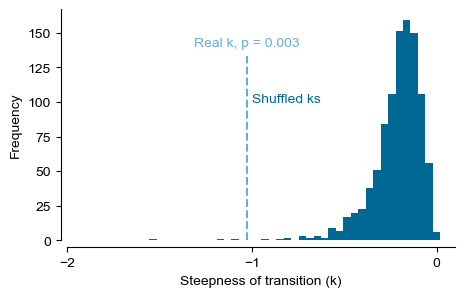

In [106]:
color_shuf = colors[1]
color_real = colors[0]

bins = np.linspace(-2, 2, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuffled_k_da, bins=bins, color=color_shuf)
ax.axvline(real_k_da, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-2, 0.1)
ax.set_xticks([-2, -1, 0])
ax.text(real_k_da, 140,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuffled_k_da > real_k_da) / num_repeats),
        ha="center",
        color=color_real)

ax.text(-1, 100, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

In [ ]:
real_k_behav, shuffled_k_behav = get_shuffled_k(subset_aligned, "time_moving", num_repeats=1000, initial_k=1)

c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, m

Text(0.5, 0, 'Steepness of transition (k)')

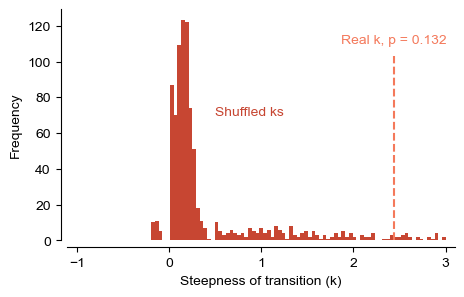

In [100]:
shuf_k = real_k_behav
real_k = shuffled_k_behav

color_shuf = colors[3]
color_real = colors[2]

bins = np.linspace(-1, 3, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuf_k, bins=bins, color=color_shuf)
ax.axvline(real_k, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-1.1, 3.1)
ax.set_xticks([-1, 0, 1, 2, 3])
ax.text(real_k, 110,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuf_k < real_k) / num_repeats),
        ha="center",
        color=color_real)

ax.text(0.5, 70, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

NameError: name 'auc_df' is not defined

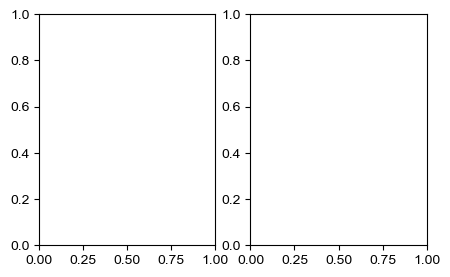

In [74]:
# Plot before/after AUC comparison
f, axes = plt.subplots(1, 2, figsize=(5, 3))

# Plot 1: Individual animal comparisons
ax = axes[0]
x_pos = np.arange(len(auc_df))
width = 0.35

bars1 = ax.bar(x_pos - width/2, auc_df['auc_before'], width, label='Before Transition',
                color=colors[0], alpha=0.7, edgecolor='k', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, auc_df['auc_after'], width, label='After Transition',
                color=colors[1], alpha=0.7, edgecolor='k', linewidth=1.5)

ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('Mean Photometry AUC', fontsize=10)
ax.set_title('Photometry AUC Before/After Transition', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(auc_df['animal'], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=9)
sns.despine(ax=ax)

# Plot 2: Change in AUC
ax = axes[1]
auc_df['auc_change'] = auc_df['auc_after'] - auc_df['auc_before']
colors_change = [colors[1] if x > 0 else colors[0] for x in auc_df['auc_change']]

ax.bar(x_pos, auc_df['auc_change'], color=colors_change, alpha=0.7, edgecolor='k', linewidth=1.5)
ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('AUC Change (After - Before)', fontsize=10)
ax.set_title('Dopamine Response Change at Transition', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(auc_df['animal'], rotation=45, ha='right', fontsize=9)
sns.despine(ax=ax)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_auc_before_after_transition", FIGSFOLDER)
plt.show()

## Export Results

In [ ]:
# Export AUC summary
auc_df.to_csv(RESULTSFOLDER / "transition_aligned_auc_summary.csv", index=False)
print(f"Exported AUC summary to {RESULTSFOLDER / 'transition_aligned_auc_summary.csv'}")

print(f"\nFigure 4B generation complete!")
print(f"Summary:")
print(f"  - {len(animals)} animals with valid transition fits")
print(f"  - {len(subset_aligned)} total trials used for alignment")
print(f"  - Mean AUC change: {auc_df['auc_change'].mean():.3f} ± {auc_df['auc_change'].std():.3f}")